In [1]:
import astropy
from astropy.io import fits 
from astropy.stats import sigma_clip
from astropy.table import Table
from astropy.time import Time
from astropy.visualization import time_support
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as sig
from scipy.stats import sigmaclip
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def dataClean(filename): 
    """ This function will remove nan values from TESS 
        20 second lightcurve data and correct time values
        Stage: complete"""
    
    #Create an array of time and flux data with nans removed    
    with fits.open(filename, mode="readonly") as hdulist:
        raw_time = hdulist[1].data['TIME']
        raw_flux = hdulist[1].data['PDCSAP_FLUX']
        raw_err = hdulist[1].data['PDCSAP_FLUX_ERR']
    data = np.vstack((raw_time, raw_flux, raw_err))
    nonan_data = data[:, ~np.isnan(data).any(axis=0)]

    #Apply time correction 
    times = nonan_data[0]
    flux = nonan_data[1]
    error = nonan_data[2]
    t_corr = []
    for i in times:
        r = i + 2457000
        t_corr.append(r)
    time = Time(t_corr, format = 'jd', scale = 'utc')
    time.format = 'iso'
    
    #Create arrays of cleaned data
    time = np.array(time)
    flux = np.array(flux)
    err = np.array(error)
    
    #Return cleaned data
    return[time,flux,err]

In [3]:
def generate_Qcurve(cleaned_data):
    """ This function will take cleaned data and dataframes of quiescent light curve
    as well as flaring light curve values
    Stage: complete"""

    #Identify quiescent light curve
    flux_smooth = sig.savgol_filter(cleaned_data[1], 1400, 3) #my opinion of the best parameters for this data
    index = np.where(cleaned_data[1] < (flux_smooth + (3*cleaned_data[2]))) #using 3 as the significance for the error for now
    q_time = cleaned_data[0][index] # time associated w/ quiescent flux
    q_flux = sig.savgol_filter(cleaned_data[1][index],2000,3) # quiescent flux
    ind2 = np.where(q_flux) #index created to assure lengths of data sets are equal
    
    #Set and index variables
    fluxes = cleaned_data[1]
    times = cleaned_data[0]
    F_err = cleaned_data[2] 
    flux_list = fluxes[ind2]
    time_list = times[ind2]
    err_list = F_err[ind2]

    #Ensure lists are same size for flare and quiescent data & have same timestamps at same indices
    qIndex = np.where(q_time) 
    err_list = err_list[qIndex]
    q_time = times[qIndex]
    q_flux = sig.savgol_filter(flux_list[qIndex],2000,3)
    
    #Create dataframes of Quiescent and Flaring lightcurves
    quiescence = pd.DataFrame({
                            'Time': q_time,
                            'Quiescent Flux':q_flux
    })

    cd = pd.DataFrame({
                                'Time': time_list[qIndex],
                                'Flux':flux_list[qIndex],
                                'Flux Error': err_list[qIndex]
    })
    return[quiescence,cd]

In [4]:
def find_ix_ranges(ix, buffer=False):
    """ Finds indexes in the range.
    
        From MC GALEX function defs"""
    
    foo, bar = [], []
    for n, i in enumerate(ix):
        if len(bar) == 0 or bar[-1] == i-1:
            bar += [i]
        else:
            if buffer:
                bar.append(min(bar)-1)
                bar.append(max(bar)+1)
            foo += [np.sort(bar).tolist()]
            bar = [i]
        if n == len(ix)-1:
            if buffer:
                bar.append(min(bar)-1)
                bar.append(max(bar)+1)
            foo += [np.sort(bar).tolist()]
    return foo

In [5]:
def get_inff(lc, clipsigma=3, quiet=True, band='NUV',
             binsize=30.):
    """ Calculates the Instantaneous Non-Flare Flux values.
    
        From MC GALEX function defs"""
    
    sclip = sigma_clip(np.array(lc['Flux']), sigma=clipsigma)
    inff = np.ma.median(sclip)
    inff_err = np.sqrt(inff*len(sclip)*binsize)/(len(sclip)*binsize)
    if inff and not quiet:
        print('Quiescent at {m} AB mag.'.format(m=gt.counts2mag(inff, band)))
    return inff, inff_err

In [6]:
def find_flare_ranges(curve,q_curve,sig,quiescence=None):
    """This function will run through the data to find 
    flares and ranges of flares. This function will return
    a table of flares ranges. 
    
    Adapted from MC GALEX function defs.
    Stage: complete"""
    
    tranges = [[min(curve['Time']), max(curve['Time'])]] 
    if not quiescence:
        q, q_err = get_inff(curve)
    else:
        q, q_err = quiescence
    flare_ranges = []
    for trange in tranges:
        ix = np.where(((np.array(curve['Flux'].values)-(sig*np.array(curve['Flux Error'].values)) >= q_curve['Quiescent Flux'])))[0]
        flareFlux = ix
        if not len(ix):
            continue
        flux_ix = []
        
        for ix_range in find_ix_ranges(ix):
            # go backwards
            consec = 0 
            err = curve.iloc[ix_range[0]]['Flux Error'] 
            
            #while flux - err > quiescence, find 2 consecutive points withing quiescent curve
            while any(curve.iloc[ix_range[0]]['Flux']-err >= q_curve['Quiescent Flux']) and ix_range[0] > 0 or (consec < 1 and ix_range[0] >0):
                err = curve.iloc[ix_range[0]]['Flux Error']

                if any(curve.iloc[ix_range[0]]['Flux']- err < q_curve['Quiescent Flux']) :
                    consec +=1
                else: 
                    consec = 0
                if (curve.iloc[ix_range[0]+1]['Time']-curve.iloc[ix_range[0]]['Time']) > 1000: 
                    break               
                ix_range = [ix_range[0] - 1] + ix_range
                
                # go forwards
            consec = 0 
            err = curve.iloc[ix_range[-1]]['Flux Error']
            while any(curve.iloc[ix_range[-1]]['Flux']-err >= q_curve['Quiescent Flux']) and ix_range[-1] != len(curve)-1 or (consec <1 and ix_range[:-1]!= len(curve)-1):
                err = curve.iloc[ix_range[-1]]['Flux Error']
                if any(curve.iloc[ix_range[-1]]['Flux']-err < q_curve['Quiescent Flux']):
                    consec += 1
                else: 
                    consec = 0
                if curve.iloc[ix_range[-1]+1]['Time']-curve.iloc[ix_range[-1]]['Time'] > 1000: 
                    break
                ix_range = ix_range + [ix_range[-1] + 1]
                
            flux_ix += ix_range
        ix = np.unique(flux_ix)
        flare_ranges += find_ix_ranges(list(np.array(ix).flatten()))
    return(flare_ranges,flareFlux)

                

In [7]:
def refine_flare_ranges(curve,q_curve, sig=3., flare_ranges=None):
    """ Identify the start and stop indexes of a flare event after
    refining the INFF by masking out the initial flare detection indexes. 
    From MC GALEX function defs."""
    time_support()
    if not flare_ranges:
        flare_ranges, _ = find_flare_ranges(curve, q_curve, sig)
    flare_ix = list(itertools.chain.from_iterable(flare_ranges))
    quiescience_mask = [False if i in flare_ix else True for i in
                        np.arange(len(curve['Time']))]
    quiescence = q_curve
    quiescence_err = (np.sqrt(curve['Flux'][quiescience_mask].sum())/curve['Flux'].sum())
    flare_ranges, flare_3sigs = find_flare_ranges(curve,q_curve,
                                                  quiescence=(quiescence,
                                                              quiescence_err),
                                                  sig=sig)
    flare_ix = list(itertools.chain.from_iterable(flare_ranges))
    not_flare_ix = list(set([x for x in range(len(curve['Time']))]) - set(flare_ix))
    
    
    
    
    
    return flare_ranges, flare_ix

In [85]:
def energyCalculation(curve,flare_ranges,binsize=20):
    """This function will calculate the energies of each flare.
        Stage: working, add errors"""
###http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?mode=browse&gname=TESS&asttype= for eff.width    
    energies = []
    fluxes = curve['Flux'][flare_ranges[1]]
    distance_cm = 11*3.086e+18
    eff_width = 3.89868e-5 
    
    for ix,flare in enumerate(flare_ranges[0]):
        flare_flux = fluxes[flare]
        energy = ((binsize*flare_flux).sum())*(4*np.pi*distance_cm**2)*eff_width
        energies.append(energy)
        #NEXT: don't forget to calculate errors
        
    return(energies)

In [9]:
def plot_flares(flare_ranges):
    """ Plots flares from flare ranges"""
    for i,v in enumerate(flare_ranges[0]):
        t = (times[v])
        f = (fluxes[v])
        f.plot(xticks=t.index, yerr=err[v],xlabel=('Flare ID:',i))


In [10]:
def FlareTable(curve,flare_ranges,energies):
    """This function will build a table of all flares.
        Stage: complete"""
    
    #Generate quiescent and flaring curves in order to index time values
    times = curve['Time']
    
    #Create empty lists to use as columns for table

    tstart = []
    tstop = []
    duration = []
    energy = list(energies)
    
    #Populate Lists
    for flare in flare_ranges[0]:
        start_ix = times[flare[0]]
        stop_ix = times[flare[-1]]
        tstart.append(start_ix)
        tstop.append(stop_ix)
        duration.append(((times[flare[-1]]-times[flare[0]])).sec)


    #Label flares    
    flareID = list(range(1,166+1)) 
    
    #Build flare table
    flareTable = pd.DataFrame({
                                "ID": flareID,
                                "Start Time": tstart,
                                "Stop Time": tstop,
                                "Duration (s)": duration,
                                "Total Energy": energy
    })
    
    return(flareTable)
        

In [11]:
TESSDATA = '/Users/katborski/Documents/GitHub/AFPSC/TESS/tess2021232031932-s0042-0000000250081915-0213-a_fast-lc.fits'
cleaned_data = dataClean(TESSDATA)

dataset = generate_Qcurve(cleaned_data)
q_curve = dataset[0]
curve = dataset[1]

ranges,flux = find_flare_ranges(curve,q_curve,3)

In [12]:
flare_ranges = refine_flare_ranges(curve,q_curve,sig=3.)


In [13]:
fe = curve['Flux Error'][flare_ranges[1]]
flux_error= pd.DataFrame({'Flux Error': fe})


In [87]:
energies = energyCalculation(curve,flare_ranges)
FlareTable(curve,flare_ranges,energies)

,ID,Start Time,Stop Time,Duration (s),Total Energy
0,1,2021-08-21 05:13:15.519,2021-08-21 05:17:55.531,280.012000,6.615767e+41
1,2,2021-08-21 10:29:36.317,2021-08-21 10:34:56.330,320.013231,8.025639e+41
2,3,2021-08-21 10:38:36.339,2021-08-21 10:42:56.350,260.010700,6.590406e+41
3,4,2021-08-21 13:56:36.822,2021-08-21 13:58:36.827,120.004781,3.286509e+41
4,5,2021-08-21 14:32:56.910,2021-08-21 14:34:16.913,80.003227,2.350442e+41
...,...,...,...,...,...
161,162,2021-09-12 17:27:35.278,2021-09-12 17:41:15.279,820.001145,2.001136e+42
162,163,2021-09-12 19:57:35.290,2021-09-12 19:59:15.290,100.000142,2.835102e+41
163,164,2021-09-12 20:46:15.294,2021-09-12 20:50:35.294,260.000360,6.601325e+41
164,165,2021-09-12 23:26:15.306,2021-09-12 23:29:35.306,200.000243,5.191761e+41


In [48]:
times = curve['Time'][flare_ranges[1]]
fluxes = curve['Flux'][flare_ranges[1]]
err = curve['Flux Error'][flare_ranges[1]]
q = q_curve['Quiescent Flux'][flare_ranges[1]]


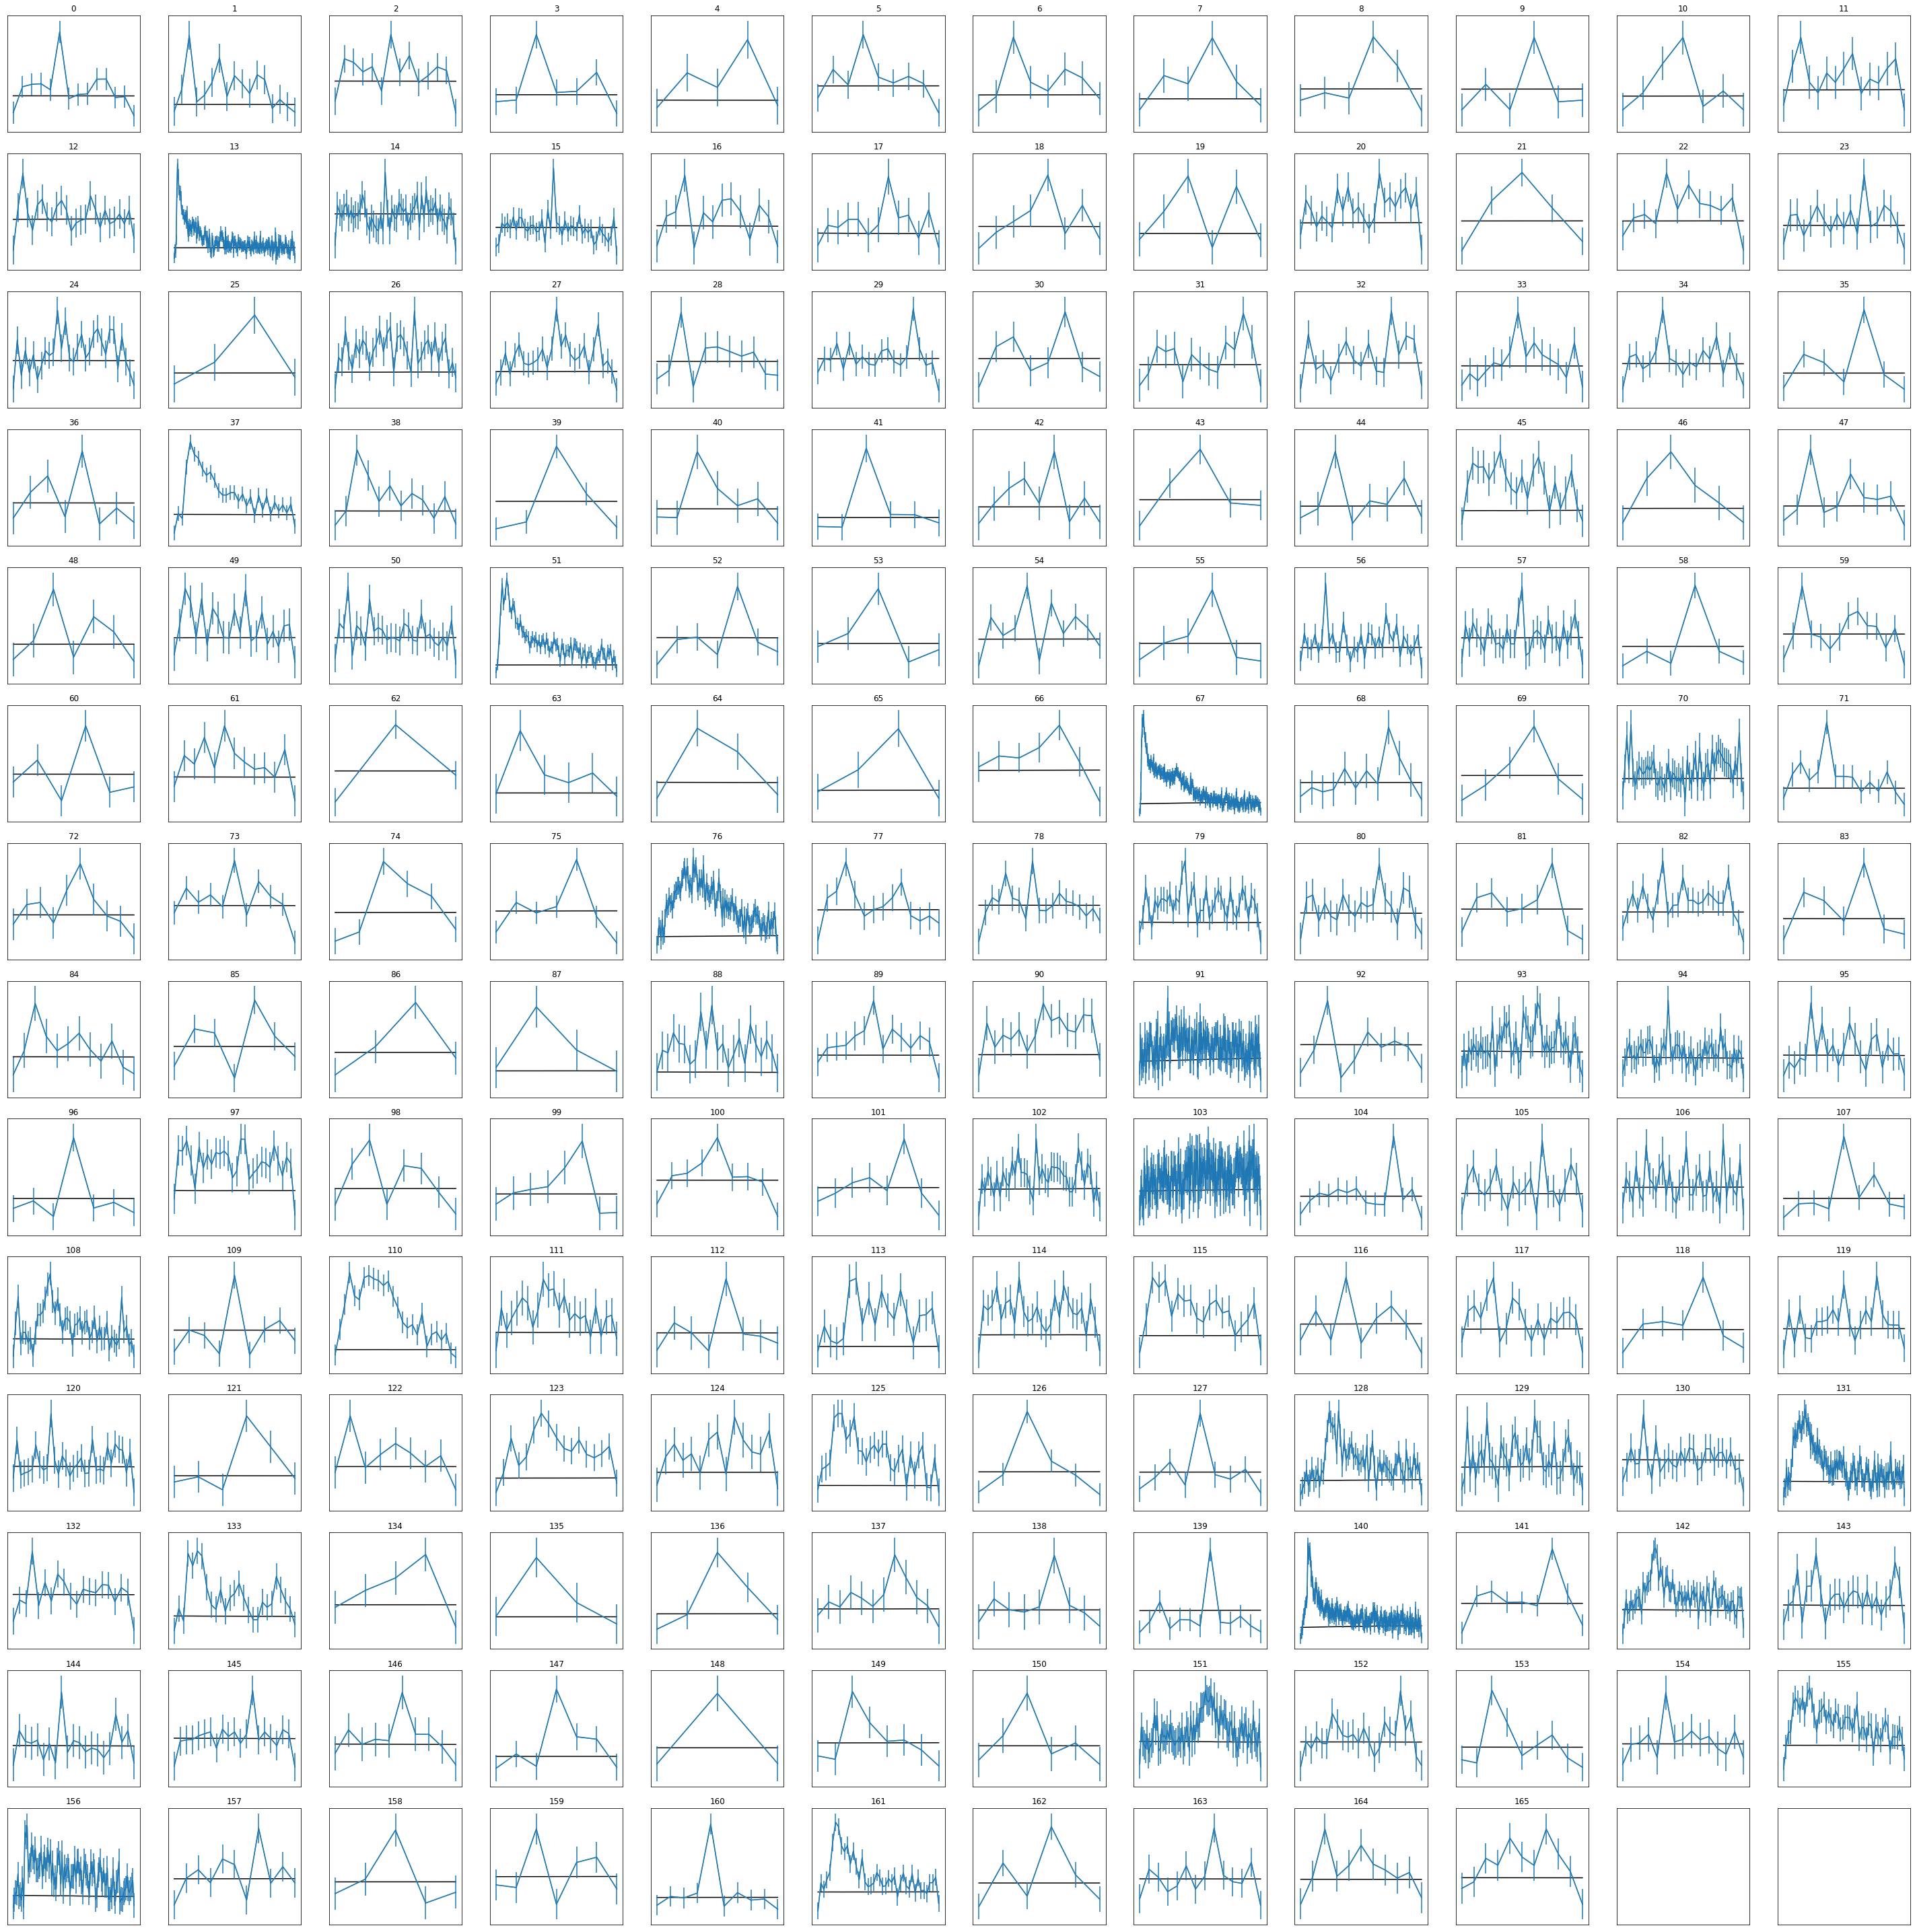

In [67]:
fig,ax = plt.subplots(14,12)
fig.set_size_inches(40,40)
fig.tight_layout()
for i,v in enumerate(flare_ranges[0]):
    t = (times[v])
    f = (fluxes[v])
    y_er = (err[v])
    quies = (q[v])
    ax.flat[i].plot(quies,color='black')
    ax.flat[i].plot(f,color='cadetblue')
    ax.flat[i].errorbar(t.index,f.values,yerr=y_er)
    plt.setp(ax, xticks=[], yticks=[]) #clearing out time/flux ticks for now to make graphs easier to look at
    ax.flat[i].set_title(i)

plt.show()
#fig.savefig(
#    'grid_of_flares_w_quiescence.jpg', dpi=1000, bbox_inches="tight", pad_inches=0
#)

In [88]:
T=times[flare_ranges[0][1]]
F=fluxes[flare_ranges[0][1]]
q
i = flare_ranges[0][1]


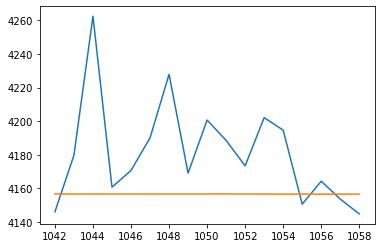

In [102]:
plt.plot(T.index,F.values)
plt.plot(T.index,q[i])